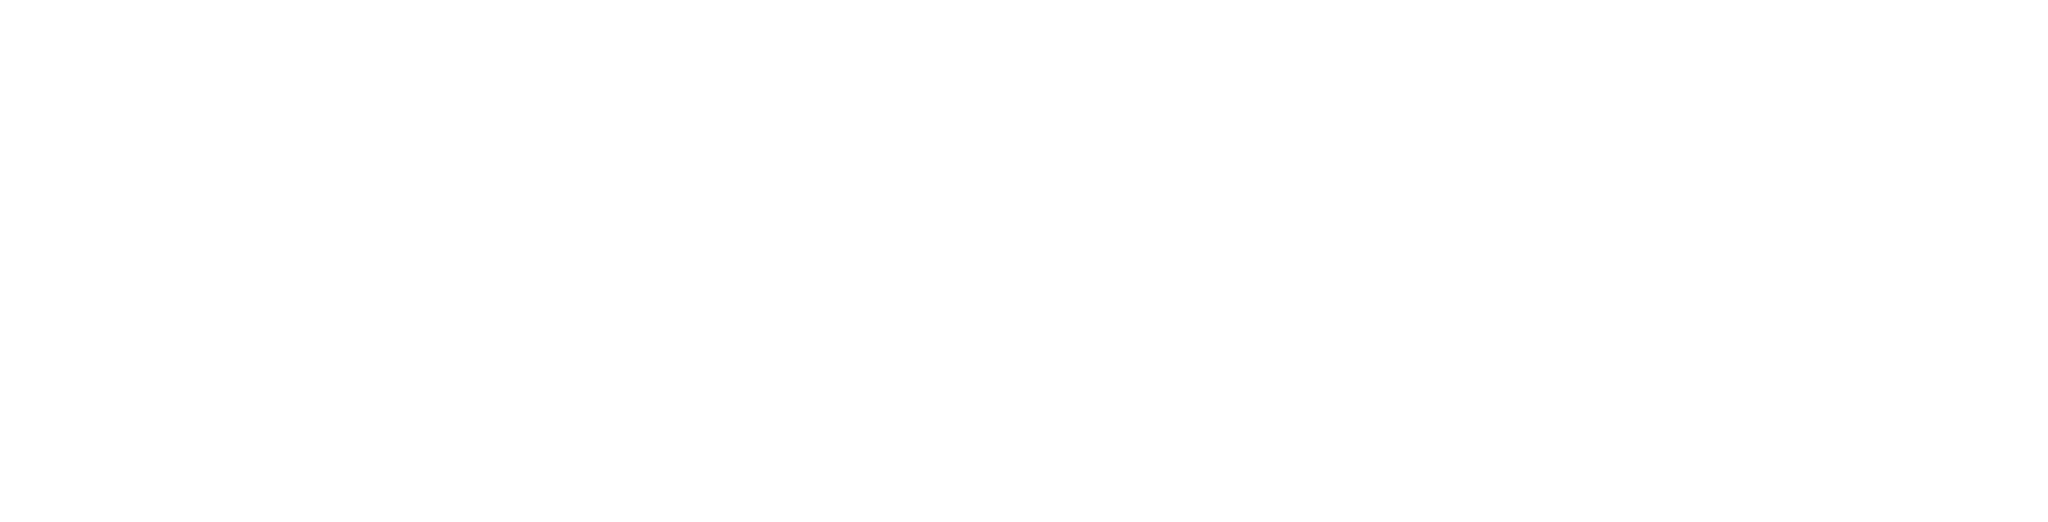

M2L School 2024 Edition, Milan, Italy.

**Reinforcement Learning Lab.**

Tutors:

*   Diego Calanzone (diego.calanzone@m2lschool.org)
*   Gianmarco Tedeschi (gianmarco.tedeschi@m2lschool.org)

This tutorial is based on:
*   HuggingFace's [TRL library](https://huggingface.co/docs/trl/index) and the provided [examples](https://huggingface.co/docs/trl/en/detoxifying_a_lm).

Notebook author: Diego Calanzone.

---
# RL03: Reinforcement Learning from (Any-) Human Feedback
---

Welcome to the last part of the RL Lab @ M2L 2024!

This notebook introduces you to an emergent research topic that merges two communities: Natural Language Processing and Reinforcement Learning. **But why?** Language models have become pervasive in research and beyond; while there is a huge knowledge gain in training from internet-scale data, it has become necessary to polish LMs towards desirable properties defined by humans, such as:


*   Politeness
*   Usefulness
*   Harmlessness
*   Impartiality

But how to define loss functions for these concepts? The traditional pre-training paradigm for LMs is not sufficient: reinforcement learning becomes useful to make these models optimize for **reward functions** that represent complex concepts. Usually, such reward functions consist of data-driven models that reflect examples annotated by humans; this is why LMs are trained with **reinforcement learning** from **human (collected) feedback** (RLHF)!

The main pipeline for RLHF consists of:


1.   Pre-trained LM to start from, e.g. [GPT-3](https://arxiv.org/abs/2005.14165).
2.   Reward model trained on datasets specific for our desired property, e.g. [DistilBERT for sentiment analysis](https://huggingface.co/lvwerra/distilbert-imdb).
3.   Fine-tuning of the pre-trained LM with a RL algorithm, e.g. [PPO](https://arxiv.org/abs/1707.06347) or [REINFORCE](https://arxiv.org/abs/2010.11364).

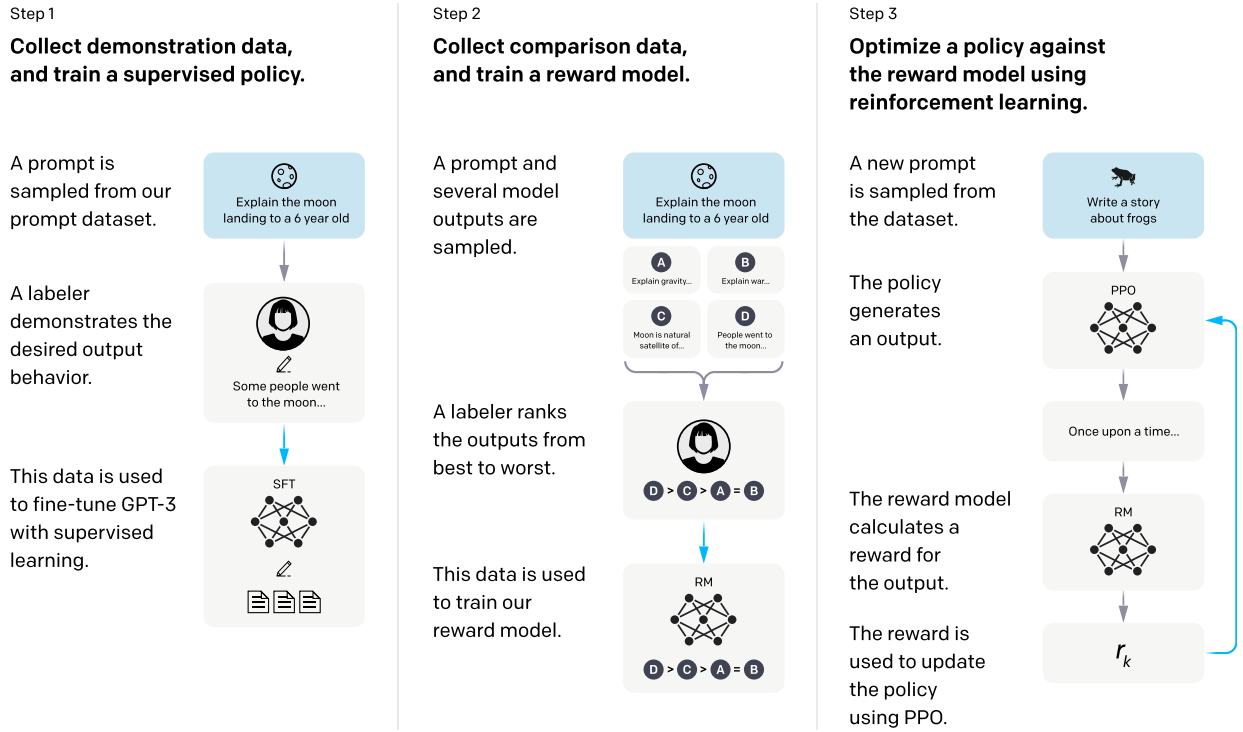













Source: [Ouyang et al. 2022](https://arxiv.org/pdf/2203.02155).

In this tutorial we will implement this pipeline with the purpose of **Detoxifying Language Models**: as they are trained on large datasets, naturally LMs learn language patterns containing hate speech, misinformation, terms augmenting inequality or offensive speech. Reducing toxicity in language models is one of the main objectives in Alignment Research, you can dive in the topic from here ([1](https://lilianweng.github.io/posts/2021-03-21-lm-toxicity/), [2](https://arxiv.org/abs/2212.08073)).

In this colab you will find some

#### ⭐ Exercises
where you need to implement missing parts in the code, or answer the quesions that test your understanding of code and algothims.
When you need to complete some code, the section is marked as:

```
# -----------------------------------#
# You code goes here
# -----------------------------------#
```
with any comments to help you to complete the task. Sometimes it is useful to have a look at further code in the cell to understand which variables you need to assign in your implementation.
Some exercises only require you to answer the questions or experiment with the code.
You can skip bonus exercises if you are short on time as the rest of the content does not depend on them. You can use the Table of content on the left to vavigate the tutorial. Let's begin!


# Pre-trained LMs

We will rely on frameworks provided by [HuggingFace](https://huggingface.co) to work with Language Models. Their website offers APIs to use open datasets, to download pre-trained language models and to use/train them on remote or local GPUs.

In [ ]:
%%capture
!pip install -q transformers accelerate datasets trl evaluate

In [ ]:
from dataclasses import dataclass, field
from typing import Optional
import torch
from datasets import load_dataset
from torch.optim import Adam
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    HfArgumentParser,
    RobertaForSequenceClassification,
    RobertaTokenizer,
)
from trl import (
    AutoModelForCausalLMWithValueHead,
    PPOConfig, PPOTrainer,
    create_reference_model, set_seed
)
from trl.core import LengthSampler


tqdm.pandas()

As language model to start from, we pick an open-source version of GPT-3: [GPT-Neo](https://github.com/EleutherAI/gpt-neo) (EleutherAI, 2021). It adds novel features such as local attention, linear attention and axial positional embeddings. It is trained on [The Pile](https://arxiv.org/pdf/2101.00027) (Gao et al. 2020), a dataset containing over 800 GB of public internet data.

This dataset was reported to contain toxic content ([Longpre et al. 2023](https://arxiv.org/pdf/2305.13169)) and so `GPT-Neo` has been shown to generate undesired textual continuations. Detoxifying LMs involves mainly language models with billions of parameters, though smaller language models such as GPT-2 are not exempt from the issue ([Gehman et al. 2020](https://aclanthology.org/2020.findings-emnlp.301.pdf)).

  #### ⭐ Exercise
  With HuggingFace, we can pick any language model from their [library](https://huggingface.co/models) by indicating the endpoint, e.g. `openai-community/gpt2`.

  Change the model endpoint in order to load [GPT-Neo-125M (source here)](https://huggingface.co/EleutherAI/gpt-neo-125m) and fill the blanks to interact with the LM.

In [ ]:
%%capture
# Now let's build the model, the reference model, and the tokenizer.
# We first load the model
# in bfloat16 to save memory using `transformers`.
# -----------------------------------#
model_name = "" # @param
# -----------------------------------#
model = AutoModelForCausalLM.from_pretrained(
    model_name, torch_dtype=torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

Now write an example prompt and encode it with the `.encode()` function of the tokenizer.

In [ ]:
# -----------------------------------#
in_string = ""
tokenizer.encode(
# -----------------------------------#

In [ ]:
# shorthand to encode including attn masks etc.
in_prompt = tokenizer(in_string, return_tensors="pt")
output = model.generate(**in_prompt, max_length=16)
print(output)
tokenizer.decode(output[0])

# Reward models

We are going to use a data-driven model as reward signal for our LM. More specifically, we are going to use a smaller language model based on a different architecture, [BERT](https://arxiv.org/abs/1810.04805) (Devlin et al. 2018), that is fine-tuned to classify toxic sentences. Reward models of this type are usually trained from a set of human annotations in order to categorize, rank or score model outputs according to a specified property, e.g. toxicity.

<img width="450px" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/reward-model.png"/>

Source: [Illustrating Reinforcement Learning from Human Feedback (RLHF), HuggingFace](https://huggingface.co/blog/rlhf).

The model we are going to use is `facebook/roberta-hate-speech-dynabench-r4-target`: it consists of a fine-tuned BERT model and a classification head to label text as hate speech or not. This model has been trained by Facebook (Meta) AI, further details can be found [here](https://arxiv.org/pdf/2012.15761)!

#### ⭐ Exercise

We thus load the reward model as we previously did with our pre-trained LM. You will notice the shape of the output differs.

Fill the blanks to inspect the model's I/O!

In [ ]:
%%capture
# We then build the reward pipeline, we will use the toxicity model to compute the reward.
# We first load the toxicity model and tokenizer.
toxicity_model_id = "facebook/roberta-hate-speech-dynabench-r4-target"
toxicity_tokenizer = RobertaTokenizer.from_pretrained(toxicity_model_id)
# We load the toxicity model in fp16 to save memory.
toxicity_model = RobertaForSequenceClassification.from_pretrained(toxicity_model_id, torch_dtype=torch.float16)

In [ ]:
# Write an example string, encode it as
# a pytorch tensor and feed it to the model!
# -----------------------------------#
encoded = toxicity_tokenizer(, return_tensors="pt")
output = toxicity_model(**
# -----------------------------------#
logits = output.logits.float()
probs = logits[:].softmax(-1)[0]

print(f"Neutral:\t{probs[0]:.3f}")
print(f"Hate:\t\t{probs[1]:.3f}")

You can test out multiple sentences to see how logits change: the outputs is tensor of shape `(batch_size, 2)` and for each sample, the two logits represent respectively how *neutral* the text is wrt. how *hate speech* it contains. We use the `.softmax()` function here to normalize the logits in `[0, 1]` (let's say probabilities), but we are going to use the raw outputs as fine-tuning turned out to be more stable for us.

# Fine-tuning with RL

## Preparing the pre-trained LM

We are going to prepare our language model for RL fine-tuning: the `AutoModelForCausalLMWithValueHead` adds a feed forward layer to the model in order to predict the value of each action i.e. next token, which is required in RL.

Moreover, we are going to define a reference copy of the pre-trained LM.

**Why?**

Firstly, we may want to change only a fraction of the parameters with fine-tuning, otherwise it would be too expensive with LLMs (billions of params). Moreover, the model will not only optimize the reward we define, but it will also take into account the shift in the language distribution from the start: steering the model too much away may make it output tokens that fool the reward function, but they don't make much sense; in a way, keeping the fine-tuned model quite similar to the pre-trained version is a tradeoff. Distribution shifts are measured with the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) and the final reward function will be:

$$
r = r_{\theta} - \lambda \cdot r_{KL}
$$

We thus create the reference model with the function provided by HuggingFace `create_reference_model` and choose to share (freeze) 6 transformer layers of the 12 present in the architecture 125M. You can find out more about the different architectures by model size from [Table 2.1 in the GPT-3 paper](https://arxiv.org/pdf/2005.14165); moreover, for efficient fine-tuning you can read more about [Low Rank Adaptation (LoRa)](https://arxiv.org/abs/2106.09685) and techniques used in LMs such as [Sparrow (DeepMind)](https://arxiv.org/abs/2209.14375).

In [ ]:
# And then we pass the loaded model to `AutoModelForCausalLMWithValueHead`.
model = AutoModelForCausalLMWithValueHead.from_pretrained(model)

# how many layers to freeze and share
# between the reference model and our fine-tuning?
n_shared_layers = 6 # @param
ref_model = create_reference_model(model, num_shared_layers=n_shared_layers)

Here, `mini_batch_size` is the amount of samples in a batch to process in a forward pass on a single gpu. In this way, it should hold that `batch_size = mini_batch_size * gradient_accumulation_steps`. Gradient accumulation is a common technique that allows to train with large batch sizes that don't fit in the available hardware: gradients are aggregated after multiple temporal steps.

In [ ]:
learning_rate = 1.47e-5 # @param
mini_batch_size = 4 # @param
batch_size = 16 # @param
gradient_accumulation_steps = 1 # @param
model_save_path = "./gpt-neo-125m-detoxified" # @param
epochs = 5 # @param

config = PPOConfig(
    model_name=model_name,
    learning_rate=learning_rate,
    ppo_epochs=epochs,
    mini_batch_size=mini_batch_size,
    batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
)

In [ ]:
# We make sure to use `Adam` optimizer on the model parameters that require gradients.
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.learning_rate)

## Building the dataset

Next, we pick a dataset of textual examples to fine-tune our language model. We choose `allenai/real-toxicity-prompts` ([source](https://huggingface.co/datasets/allenai/real-toxicity-prompts)), which consists of a collection of prompts and continuations labeled with different toxicity labels.

Example prompt:
```
{ "text": "Hmm, I'm getting James Toney \"Look at this", "toxicity": null, "profanity": null, "sexually_explicit": null, "flirtation": null, "identity_attack": null, "threat": null, "insult": null, "severe_toxicity": null }
```

Example continuation:
```
{ "text": " body, do I look like I use steroids?\"", "profanity": 0.06854968, "sexually_explicit": 0.25901484, "identity_attack": 0.07492801, "flirtation": 0.48981047, "threat": 0.118943624, "insult": 0.06990354, "severe_toxicity": 0.04255618, "toxicity": 0.12377684 }
```

Our data pre-processing pipeline will roughly consist of the following stages:


*   Loading the original dataset
*   Filtering out the least informative samples
*   Encoding the strings into sequences of tokens



#### ⭐ Exercise
Many examples in the dataset are neutral, that is the toxicity scores are low. We need sufficiently informative samples for the LM to learn to avoid toxic content. The method `filter_fn` returns a boolean value (to keep or not to keep) for each sample, keep the ones with valid toxicity (not None) and higher than `0.3`.

In [ ]:
def build_dataset(
    config, dataset_name="allenai/real-toxicity-prompts", input_min_text_length=5, input_max_text_length=10
):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.

    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """

    def filter_fn(sample):
        """ Flags batch samples by custom logic """
        toxicity = sample["prompt"]["toxicity"]
        # -----------------------------------#
        # toxicity should not be None and above e.g. 0.3
        return
        # -----------------------------------#

    def tokenize(sample):
        """ Encodes the prompt and the expected continuation """
        prompt = sample["prompt"]["text"]
        continuation = sample["continuation"]["text"]
        # in this task we consider the prompt (neutral) and the continuation (potentially toxic)
        # and see how the model extends the sequence
        sample["input_ids"] = tokenizer.encode(prompt + continuation)[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    # preparing the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    tokenizer.pad_token = tokenizer.eos_token

    # loading and filtering the dataset with a custom fn
    ds = load_dataset(dataset_name, split="train")
    ds = ds.filter(filter_fn, batched=False)

    # randomly takes a length in within the specified range
    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    # input the sample tokenization function to process a whole batch
    # -----------------------------------#
    # mapping the dataset with the tokenizatin function
    ds = ds.map(, batched=False)
    # -----------------------------------#
    ds.set_format(type="torch")
    ds = ds.train_test_split(test_size=0.2, shuffle=False)["train"]

    return ds

It has been shown [here](https://huggingface.co/docs/trl/en/detoxifying_a_lm#designing-the-problem) that extending the context length makes the model more prone to reveal toxic content.

We pick a random length in the range `[10, 20]`.

In [ ]:
# We retrieve the dataloader by calling the `build_dataset` function.
min_input_length = 10 # @param
max_input_length = 20 # @param
dataset = build_dataset(config, input_min_text_length=min_input_length, input_max_text_length=max_input_length)

# set seed before initializing value head for deterministic eval
set_seed(42)

def collator(data):
    return {key: [d[key] for d in data] for key in data[0]}

## Setting up the training pipeline

We now put together the previous two stages in the training pipeline based on PPO. In principle, this algorithm keeps training stable by imposing constraints on the gradient update.


<img width="500px" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/rlhf.png" />


In summary, each PPO step consists of:


1.   Feeding the RL policy (LM to fine-tune) the prompts
2.   Taking the next-token distributions from the RL policy and computing the divergence from the initial pre-trained LM distributions
3.   Providing the RL policy outputs to the reward model in order to obtain our task reward
4.   Computing the final reward $r = r_{\theta} - \lambda \cdot r_{KL}$ and thus maximizing it with gradient descent.



In [ ]:
# We then build the PPOTrainer, passing the model, the reference model, the tokenizer
ppo_trainer = PPOTrainer(
    config,
    model,
    ref_model=ref_model,
    tokenizer=tokenizer,
    dataset=dataset,
    data_collator=collator,
    optimizer=optimizer,
)

In [ ]:
toxicity_model = toxicity_model.to(
    ppo_trainer.accelerator.device
)

In [ ]:
# LM generation parameters set to default for RL fine-tuning
# Also possible to set: "pad_token_id": tokenizer.eos_token_id
generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id,
}

# taking a random output length in range
output_min_length = 20
output_max_length = 30
output_length_sampler = LengthSampler(output_min_length, output_max_length)
model_save_path = model_save_path

In [ ]:
max_steps = 25 # @param

#### ⭐ Exercise
Complete the training pipeline by filling the blanks. Add another list to trace from the statistics the policy KL divergence, namely `ppo/policy/policykl`.

You can then plot different learning curves: how does the model converge?

In [ ]:
losses = []
mean_rewards = []
# -----------------------------------#
# add an empty list for KL values
# -----------------------------------#
progress_bar = tqdm(ppo_trainer.dataloader)
steps = 0

for batch in progress_bar:
    if steps >= max_steps: break
    query_tensors = batch["input_ids"]

    # Get response from the policy model
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        # Feed the query tensors to the pipeline
        # -----------------------------------#
        # requires the query and the generation args (using **)
        response = ppo_trainer.generate(
        # -----------------------------------#
        response_tensors.append(response.squeeze()[-gen_len:])

    # taking readable model outputs
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    # Feeding the model outputs to the reward model
    texts = batch["response"]
    toxicity_inputs = toxicity_tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(
        ppo_trainer.accelerator.device
    )

    # Take the logits from the toxicity_model as previously done
    # we want to maximize the neutrality (thus pushing down the hate label)
    # -----------------------------------#
    logits = toxicity_model().logits.float()
    # remember, type(logits) = torch.Tensor(batch_size, 2), we need
    # the first column in list format
    toxicity_labels = logits[
    # -----------------------------------#
    rewards = [torch.tensor(output) for output in toxicity_labels]

    # -----------------------------------#
    # Run PPO step: what does the function need as input?
    # Hint: https://huggingface.co/docs/trl/main/en/ppo_trainer#starting-the-training-loop
    # you should have all the ingredients!
    stats = ppo_trainer.step(
    # -----------------------------------#
    ppo_trainer.log_stats(stats, batch, rewards)

    losses.append(stats["ppo/loss/total"])
    mean_rewards.append(stats["ppo/returns/mean"])

    # -----------------------------------#
    # Can you extract the policy KL stats and append it to our new list?
    kl_values.append(
    # -----------------------------------#

    progress_bar.set_description(f"tot. loss: {stats['ppo/loss/total']}")

    # Save model every X epochs
    # if epoch % 100 == 0:
    #     if ppo_trainer.accelerator.is_main_process:
    #         ppo_trainer.save_pretrained(model_save_path)
    steps += 1

In [ ]:
import matplotlib.pyplot as plt

plt.title("Aggregated PPO learning curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.plot(losses)
plt.grid()

In [ ]:
plt.title("Mean reward")
plt.xlabel("Steps")
plt.ylabel("r")
plt.plot(mean_rewards)
plt.grid()

In [ ]:
plt.title("Distribution Shift (KL Divergence)")
plt.xlabel("Steps")
plt.ylabel("Policy KL")
plt.plot(kl_values)
plt.grid()

# Evaluation

We now load the final fine-tuned model (`ybelkada/gpt-neo-125m-detox`) that we would get at the end of this training loop.

We evaluate it with handy functions provided in the `evaluate` framework by HuggingFace. This library allows to obtain reproducible scores in evaluating LLMs, a crucial phase in writing research papers.

In [ ]:
import evaluate
import numpy as np

toxicity = evaluate.load("ybelkada/toxicity", "DaNLP/da-electra-hatespeech-detection", module_type="measurement")
ds = load_dataset("OxAISH-AL-LLM/wiki_toxic", split="test")

In [ ]:
%%capture
# instantiating the initial pre-trained LM as reference
base_model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M", device_map={"": "cuda"}, torch_dtype=torch.bfloat16)
base_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
base_tokenizer.pad_token_id = base_tokenizer.eos_token_id
base_tokenizer.padding_side = "left"

In [ ]:
%%capture
# the fine-tuned model we would obtain from the pre-training loop above
# otherwise comment this out and use:
# ft_model = model
# ft_tokenizer = tokenizer

ft_model = AutoModelForCausalLM.from_pretrained("ybelkada/gpt-neo-125m-detox", device_map={"": "cuda"}, torch_dtype=torch.bfloat16)
ft_tokenizer = AutoTokenizer.from_pretrained("ybelkada/gpt-neo-125m-detox")
ft_tokenizer.pad_token_id = ft_tokenizer.eos_token_id
ft_tokenizer.padding_side = "left"

In [ ]:
MODELS_TO_TEST = [
    {"id": "EleutherAI/gpt-neo-125M", "model": base_model, "tokenizer": base_tokenizer},
    {"id": "ybelkada/gpt-neo-125m-detox", "model": ft_model, "tokenizer": ft_tokenizer}
]

In [ ]:
NUM_SAMPLES = 256 # @param
BATCH_SIZE = 32 # @param
context_length = 500 # @param
max_new_tokens = 24 # @param
device = "cuda"

#### ⭐ Exercise
We are now writing a nested loop to evaluate our models on the same dataset. Fill the blanks to compute toxicity scores and aggregate the results. Questions:


*   Does fine-tuning improve the scores wrt. the baseline?
*   Voce elenco



In [ ]:
input_texts = []
toxicities = {}

for model_to_test in MODELS_TO_TEST:

  input_texts = []
  model_id = model_to_test["id"]
  model = model_to_test["model"]
  tokenizer = model_to_test["tokenizer"]

  print(f"[-] Evaluating: {model_id}")

  i = 0
  for example in tqdm(ds):

      input_text = example["comment_text"]
      input_texts.append(input_text[:2000])

      if i > NUM_SAMPLES:
          break


      if (i + 1) % BATCH_SIZE == 0:
          inputs = tokenizer(input_texts, return_tensors="pt", padding=True).to(device)
          inputs.input_ids = inputs.input_ids[:context_length]
          inputs.attention_mask = inputs.attention_mask[:context_length]
          outputs = model.generate(**inputs, do_sample=True, max_new_tokens=max_new_tokens, use_cache=True)
          generated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)

          # removing the prefix
          generated_texts = [
              generated_text.replace(input_texts[i], "") for i, generated_text in enumerate(generated_texts)
          ]
          # -----------------------------------#
          # passing the processed model predictions
          toxicity_score = toxicity.compute(predictions=
          # -----------------------------------#
          input_texts = []

          if model_id not in toxicities:
              toxicities[model_id] = []
          toxicities[model_id].extend(toxicity_score["toxicity"])
      i += 1

  # compute mean & std using np
  mean = np.mean(toxicities[model_id])
  std = np.std(toxicities[model_id])


In [ ]:
for model in MODELS_TO_TEST:
  print(f"\nModel: \t {model['id']}")
  print(f"Toxicity mean: \t {np.mean(toxicities[model['id']]):.3f}")
  print(f"Toxicity std: \t {np.std(toxicities[model['id']]):.3f}")

If everything ran correctly, we should observe a **lower toxicity score** for the detox model (our fine-tuning)!

### ⭐ Bonus exercise

You can compare your detox model with alternative LMs of similar size:


*   `openai-community/gpt2`
*   `facebook/opt-350m`
*   `bigscience/bloom-560m`

Questions:
*    Which models are the best?
*    Try with larger LLMs, e.g. `openai-community/gpt2-xl`, `EleutherAI/gpt-neo-2.7B`, `meta-llama/Llama-2-7b-hf` (on 15GB of VRAM you can load 6B models with `bfloat16`): does scaling reduce toxicity?





# Beyond reward models (DPO)
We have illustrated above the traditional RLHF pipeline, which relies on a reward model that provides a feedback signal to the language model; this allows a language model to output with higher probability desired answers that the reward model can indicate. However, training a reward model can introduce complexity in the design phase and recently, [Rafailov et al.](https://arxiv.org/abs/2305.18290) illustrated that it is possible to optimize a language model **directly** with **preference data**!

This is the case for [**Direct Preference Optimization (DPO)**](https://arxiv.org/abs/2305.18290), which leverages an analytical mapping between preference data (desired outcomes vs. rejected ones) and the optimal policy (our target), such that the loss function is expressed only terms of the current policy and the reference.

<img width="500px" src="https://media.licdn.com/dms/image/D5612AQGdmu9B-4ALNw/article-cover_image-shrink_720_1280/0/1696967299080?e=2147483647&v=beta&t=YfG_BPfZ-iWijJQUeqgNpX5hiqNcjgpJNqEtuWlWqm0"/>

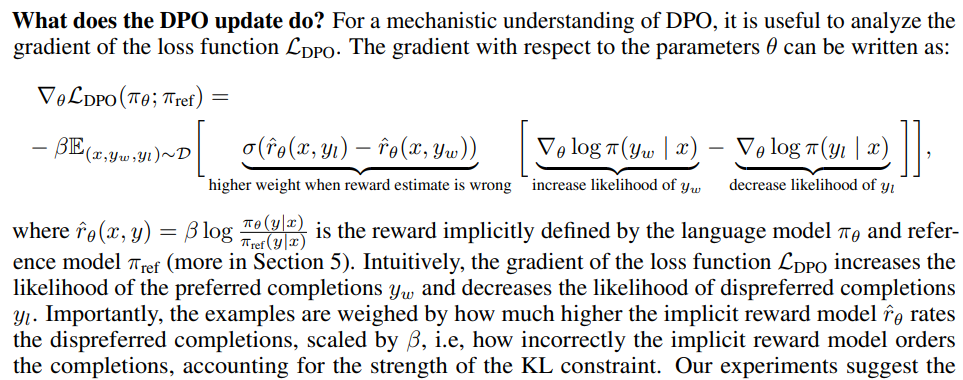

Source: [Rafailov et al.](https://arxiv.org/abs/2305.18290)

where $y_w$ and $y_l$ are respectively the preferred and the dispreferred conditional outputs.

The Transformers Reinforcement Learning (TRL) library implements also DPO with an all-in-one class:
```
    dpo_trainer = DPOTrainer(
        model,                 # base model from SFT pipeline
        model_ref,             # typically a copy of the SFT trained base model
        beta=0.1,              # temperature hyperparameter of DPO
        train_dataset=dataset, # dataset prepared above
        tokenizer=tokenizer,   # tokenizer
        args=training_args,    # training arguments e.g. batch size, lr, etc.
    )
    dpo_trainer.train()
```

where the `dataset` consists in samples of the form:
```
    {
        "prompt": [
            "Question: " + question + "\n\nAnswer: "
            for question in samples["question"]
        ],
        "chosen": samples["response_j"],   # rated better than k
        "rejected": samples["response_k"], # rated worse than j
    }
```

The pipeline thus consists in the following steps:
1. A supervised fine-tuning step of the language model on task data, usually involving efficient fine-tuning techniques such as [Low Rank Adapters (LoRA)](https://arxiv.org/abs/2106.09685).
2. Gathering pairwise preferences.
3. Optimizing the LM with DPO.

### Drawbacks and proposal for a general approach

Reinforcement Learning from Human Feedback (RLHF) relies on two assumptions: firstly, pairwise preferences can be represented by pointwise rewards; secondly, reward models trained on such pointwise rewards can provide informative feedback to out-of-distribution outcomes generated by the policy. Direct Preference Optimization (DPO) tackles the second assumption.

However, both RLHF and DPO rely on the first assumption through [Bradley-Terry modelisation](https://en.wikipedia.org/wiki/Bradley–Terry_model): this can be problematic as models trained with these methods are more prone to overfitting the preference set, especially when such preferences are (nearly) deterministic.

[Azar et al. 2023](https://arxiv.org/abs/2310.12036) thus propose a general approach, **Identity Preference Optimisation (IPO)**, which introduces the *$\Psi$-preference optimisation objective* ($\Psi\text{PO}$):

$$
\max_{\pi} \mathbb{E}_{\begin{array}{l}
x \sim \rho \\
y \sim \pi(. \mid x) \\
y' \sim \mu(. \mid x)
\end{array}} \left[ \Psi\left(p^{*}(y \succ y' \mid x)\right)\right]
- \tau D_{\text{KL}}\left(\pi \, \| \, \pi_{\text{ref}}\right)
$$

where the net likelihood in the preference pair, $p^*(y \succ y' \mid x)$, is passed to a general non-decreasing function $\Psi(x)$. The authors illustrate that RLHF and DPO are instances of the defined objective and they are empirically inferior to $\Psi\text{PO}$, for $\Psi(x)$ properly formulated.

### ⭐ Bonus exercise
You can dive in preference optimisation with DPO/IPO with a [variety of preference datasets](https://huggingface.co/collections/argilla/preference-datasets-for-dpo-656f0ce6a00ad2dc33069478) and [resources provided by HuggingFace](https://huggingface.co/blog/dpo-trl).


You can experiment with the implementation of **IPO** on Transformer Reinforcement Learning (TRL) by passing the argument `loss_type="IPO"` to `DPOTrainer`. More information can be found in [this dedicated blog post](https://huggingface.co/blog/pref-tuning).

# 🥳 Congratulations on completing the RL tutorial!

<img src="https://static.wikia.nocookie.net/looneytunes/images/a/a4/THAT%27SALLGIFS.gif/revision/latest?cb=20160806162644" />

Credits: Warner Bros. Entertainment Inc.

Thank you for attending this tutorial. We have reviewed the basics of reinforcement learning with tabular algorithms, introduced policy gradient algorithms and explored the intersection between NLP and RL, RLHF. To know more about techniques in RLHF, you can check [this](https://arxiv.org/pdf/2312.14925) survey from [Kauffmann et al 2024](https://arxiv.org/pdf/2312.14925).